## Exam III: CSCI4390-6390 (100 points)

This is a take-home exam. It is due 11:59:59pm on Thursday, Dec 8 via submitty. You are expected to abide by the honor code, i.e., all work must be your own, and you are not allowed to discuss any aspect of exam with anyone except the TA or the professor. You are also not allowed to use the internet except to lookup numpy/python documentation, the book site, class notes/videos, or to ask clarification questions on campuswire. **You cannot use any other library other than numpy (e.g., no pytorch, sklearn, etc); you can use pandas only for data processing**. You must sign the declaration below that you will abide by the honor code.

#### **Honor Code Declaration**: Please sign with your name to acknowledge that you agree to abide by the honor code, and demonstrate the highest level of academic integrity.

Pranjal Jain

#### Download Dataset: Download the [Wine Dataset](https://archive.ics.uci.edu/ml/datasets/wine). It has 14 attributes, and 178 points. The first attribute is the class/cluister variable. Store the dataset in your current directory and use "./wine.data" as its name. Do not submit the dataset as part of your answer on submitty. Read in the dataset, and use sklearn MinMaxScaler to scale all the attribute values between 0 and 1 (except for the class attribute). Use this transformed dataset for the **all** the questions below. 

#### Q1. K-Means: (Total 15 points)  For this question, we will use the first attribute as the true class for evaluation, and the remaining 13 attributes as the actual attributes for use in K-means clustering. Use the minmax scaled data. Answer the following:

##### a) (10 points) Code and run K-Means with $K=3$ using convergence threshold $\epsilon=0.001$. Report the i) final means, ii) the number of points in each cluster, and iii) the final SSE value. Set random seed as 42, and find the initial clusters using the "farthest means" approach, i.e., after the first mean selected at random as one of the data points, the remaining two means should be points that are the farthest from already selected means.

##### b) (5 points) What is the silhouette coefficient for point $x_0$, and the silhouette coefficent for the **ground truth** clustering. Use Euclidean distance for the proximity matrix.

In [146]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, normalize
from scipy.stats import multivariate_normal
from scipy.special import logsumexp


In [69]:
df = pd.read_csv('./wine.data', sep=",", header=None)
D = np.array(df)
y = D[:,0]
D = D[:,1:]
D = MinMaxScaler().fit_transform(D)
print(y.shape,D.shape)

(178,) (178, 13)


In [176]:
D

array([[0.84210526, 0.1916996 , 0.57219251, ..., 0.45528455, 0.97069597,
        0.56134094],
       [0.57105263, 0.2055336 , 0.4171123 , ..., 0.46341463, 0.78021978,
        0.55064194],
       [0.56052632, 0.3201581 , 0.70053476, ..., 0.44715447, 0.6959707 ,
        0.64693295],
       ...,
       [0.58947368, 0.69960474, 0.48128342, ..., 0.08943089, 0.10622711,
        0.39728959],
       [0.56315789, 0.36561265, 0.54010695, ..., 0.09756098, 0.12820513,
        0.40085592],
       [0.81578947, 0.66403162, 0.73796791, ..., 0.10569106, 0.12087912,
        0.20114123]])

In [40]:
class KMeans:
    def __init__(self, X, num_clusters,eps=0.001):
        self.K = num_clusters # np. of clusters
        self.max_iterations = 100 # max iteration
        self.num_examples, self.num_features = X.shape
        self.eps = eps
        
    # randomly initialize centroids
    def initialize_random_centroids(self, X):
        centroids = np.zeros((self.K, self.num_features)) # row , column full with zero
        centroids[0] = X[np.random.choice(range(self.num_examples))]
        dist1 = 0
        dist2 = 0
        for i in range(X.shape[0]):
            if la.norm(centroids[0]-X[i,:])>dist1:
                dist1 = la.norm(centroids[0]-X[i,:])
                centroids[1] = X[i,:]
        for i in range(X.shape[0]):
            if (la.norm(centroids[0]-X[i,:]) + la.norm(centroids[1]-X[i,:]))>dist2:
                dist2 = la.norm(centroids[0]-X[i,:]) + la.norm(centroids[1]-X[i,:])
                centroids[1] = X[i,:]
        return centroids
    
    # create cluster Function
    def create_cluster(self, X, centroids):
        clusters = [[] for _ in range(self.K)]
        for point_idx, point in enumerate(X):
            closest_centroid = np.argmin(np.sqrt(np.sum((point-centroids)**2, axis=1))) 
            clusters[closest_centroid].append(point_idx)
        return clusters 
    
    # new centroids
    def calculate_new_centroids(self, cluster, X):
        centroids = np.zeros((self.K, self.num_features))
        for idx, cluster in enumerate(cluster):
            new_centroid = np.mean(X[cluster], axis=0) # find the value for new centroids
            centroids[idx] = new_centroid
        return centroids
    
    # prediction
    def predict_cluster(self, clusters, X):
        y_pred = np.zeros(self.num_examples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                y_pred[sample_idx] = cluster_idx
        return y_pred
    
    #SSE
    def get_sse(self,X,clusters,centroids):
        sse=0
        inter_clust_dist = (la.norm(centroids[0]-centroids[1]) + la.norm(centroids[0]-centroids[2]) + la.norm(centroids[2]-centroids[1]))/3
        intra_clust_dist =[]
        for k in range(centroids.shape[0]):
            dist = 0
            for clust in clusters:
                for i in clust:
                    sse+= la.norm(centroids[k]- X[i,:])
                    dist+= la.norm(centroids[k]- X[i,:])
            intra_clust_dist.append(dist/len(clust))
        return sse, inter_clust_dist, intra_clust_dist
    
    # fit data
    def fit(self, X):
        centroids = self.initialize_random_centroids(X) # initialize random centroids
        diff =1
        while diff>self.eps:
            clusters = self.create_cluster(X, centroids) # create cluster
            previous_centroids = centroids
            centroids = self.calculate_new_centroids(clusters, X) # calculate new centroids
            diff = la.norm(centroids - previous_centroids) # calculate difference
            sse, inter_clust_dist, intra_clust_dist = self.get_sse(X,clusters,centroids)
            #if not diff.any():
            #    break
        y_pred = self.predict_cluster(clusters, X) # predict function
        return y_pred, centroids, clusters, sse, inter_clust_dist, intra_clust_dist
            

In [41]:
np.random.seed(42)
num_clusters = 3 # num of cluster
Kmeans = KMeans(D, num_clusters)
y_pred,centroids, clusters, sse, inter_clust_dist, intra_clust_dist = Kmeans.fit(D)

In [42]:
print("SSE: ",sse,"\n centroids: ",centroids)
for i in range(len(clusters)):
    print("cluster",i,' :',len(clusters[i]))

SSE:  450.86755377259027 
 centroids:  [[0.69129555 0.23837033 0.57630605 0.35265662 0.39765886 0.64986737
  0.55485232 0.29114659 0.47755399 0.34826726 0.4808005  0.68825021
  0.57211676]
 [0.55371517 0.50736263 0.56558666 0.54851425 0.3115942  0.24273158
  0.10101762 0.60747318 0.23213954 0.50808071 0.17232584 0.15628816
  0.24326592]
 [0.3086163  0.23849292 0.47584958 0.49542734 0.25490884 0.42096774
  0.35837757 0.45100426 0.37788745 0.14243642 0.4686074  0.56085313
  0.16027794]]
cluster 0  : 65
cluster 1  : 51
cluster 2  : 62


In [43]:
inter_clust_dist, intra_clust_dist

(0.8852545405855313,
 [2.393906467438757, 2.6315960653060073, 2.2465547861679758])

In [46]:
for k in range(centroids.shape[0]):
            for j in range(len(clusters)):
                for i in clusters[j]:
                    if i == 0:
                        dist = (intra_clust_dist[k]-inter_clust_dist)/max(intra_clust_dist[k],inter_clust_dist)
print("silhouette coeff of X0:", dist)
                        

silhouette coeff of X0: 0.605950165989257


In [156]:
centroids_true = []
c1=[]
cnt1=0
c2=[]
cnt2=0
c3=[]
cnt3=0
for i in range(y.shape[0]):
    if y[i]==1:
        c1.append(D[i,:])
        cnt1+=1
    if y[i]==2:
        c2.append(D[i,:])
        cnt2+=1
    if y[i]==3:
        c3.append(D[i,:])
        cnt3+=1
c1 = np.mean(c1,axis=0)
c2 = np.mean(c2,axis=0)
c3 = np.mean(c3,axis=0)
inter_clust_dist_true = (la.norm(c1-c2) + la.norm(c1-c3) + la.norm(c3-c2))/3
d1=0
d2=0
d3=0
for i in range(y.shape[0]):
    if y[i]==1:
        d1+=la.norm(c1- D[i,:])
    if y[i]==2:
        d2+=la.norm(c2- D[i,:])
    if y[i]==3:
        d3+=la.norm(c3- D[i,:])
d1 = d1/cnt1
d2 = d2/cnt2
d3 = d3/cnt3

In [96]:
s1 = (((la.norm(c1-c2) - d1)+ (la.norm(c1-c3) - d1))/2)/max(((la.norm(c1-c2) - d1)+ (la.norm(c1-c3) - d1))/2, d1)
s2 = (((la.norm(c2-c1) - d2)+ (la.norm(c2-c3) - d2))/2)/max(((la.norm(c2-c1) - d2)+ (la.norm(c2-c3) - d2))/2, d2)
s3 = (((la.norm(c3-c1) - d3)+ (la.norm(c3-c2) - d3))/2)/max(((la.norm(c3-c1) - d3)+ (la.norm(c3-c2) - d3))/2, d3)
print("silhouette coeff of cluster 1",s1)
print("silhouette coeff of cluster 2",s2)
print("silhouette coeff of cluster 3",s3)

silhouette coeff of cluster 1 1.0
silhouette coeff of cluster 2 0.3653404447869661
silhouette coeff of cluster 3 1.0


#### Q2. Kernel K-Means: (Total 15 points) Given the minmax scaled data, assume that the initial clusters are given as:
$C_0 = [43, 59, 60, 61, 62, 63, 64, 65, 66, 67, 71, 72, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,  139, 140, 142, 143, 146, 147, 148, 149, 150, 151, 152, 153, 154, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 177]$

$C_1 = [2, 3, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 26, 27, 30, 31, 33, 49, 50, 51, 52, 53, 55, 57, 58, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138]$

$C_2 = [0, 1, 4, 8, 9, 19, 20, 21, 22, 23, 24, 25, 28, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 54, 56, 68, 69, 70, 73, 74, 78, 95, 136, 141, 144, 145, 155, 157, 168, 173, 174, 175, 176]$

##### a) (CSCI4390: 15 points, CSCI6390: 10 points) Show one round of Kernel K-means using the Gaussian Kernel, with spread = 0.5. Show the i) updated cluster assignments, and ii) the percentage of points that change clusters (after 1 step).

##### b) (**CSCI6390 Only: 5 points**) Compute the Kernel SSE value (after 1 step). Also compute the variation of information metric for the clustering (see Eq 17.10) after 1 step. You must implement this on your own using numpy functions (but no direct functions).

In [128]:
clusters =[[43,59,60,61,62,63,64,65,66,67,71,72,75,76,77,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,139,140,142,143,146,147,148,149,150,151,152,153,154,156,158,159,160,161,162,163,164,165,166,167,169,170,171,172,177],
[2,3,5,6,7,10,11,12,13,14,15,16,17,18,26,27,30,31,33,49,50,51,52,53,55,57,58,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,137,138],
[0,1,4,8,9,19,20,21,22,23,24,25,28,29,32,34,35,36,37,38,39,40,41,42,44,45,46,47,48,54,56,68,69,70,73,74,78,95,136,141,144,145,155,157,168,173,174,175,176]]

def kernelize(x, y, spread):
    K = np.dot(x, y.T)
    GK = (2 * K) / (2 * spread)
    GK = np.exp(GK)
    return GK




In [133]:

def Kernel_KMeans(K,k):
    t=0
    while(True):
        sqnorm=np.zeros(3)
        for i in range(len(clusters)):
            sqnorm[i] = np.sum(np.outer(K[clusters[i]], K[clusters[i]]) / (len(clusters[i])**2))
        avg = np.zeros([D.shape[0],len(clusters)])
        for j in range(D.shape[0]):
            for i in range(len(clusters)):
                avg[j,i]=np.sum(np.outer(K[clusters[i]], D[i,:])/len(clusters[i]))
        d = np.zeros([D.shape[0],len(clusters)])
        clus = []
        for j in range(D.shape[0]):
            for i in range(len(clusters)):
                d[j,i] = sqnorm[i] - 2*avg[j,i]
            idx = np.argmin(d[j,i])
            clus.append( np.union1d(clusters[i],D[j,:]))
        return clus
        t+=1
        if t==1:
            break

In [126]:
GK = kernelize(D,D,0.5)
#Kernel_KMeans(GK,3)
GK.shape

(178, 178)

In [135]:
clusts = Kernel_KMeans(GK,3)

In [141]:
clusts[0:3]

[array([  0.        ,   0.1916996 ,   0.25773196,   0.28301887,
          0.37201365,   0.45528455,   0.56134094,   0.57219251,
          0.57383966,   0.59305994,   0.61956522,   0.62758621,
          0.84210526,   0.97069597,   1.        ,   4.        ,
          8.        ,   9.        ,  19.        ,  20.        ,
         21.        ,  22.        ,  23.        ,  24.        ,
         25.        ,  28.        ,  29.        ,  32.        ,
         34.        ,  35.        ,  36.        ,  37.        ,
         38.        ,  39.        ,  40.        ,  41.        ,
         42.        ,  44.        ,  45.        ,  46.        ,
         47.        ,  48.        ,  54.        ,  56.        ,
         68.        ,  69.        ,  70.        ,  73.        ,
         74.        ,  78.        ,  95.        , 136.        ,
        141.        , 144.        , 145.        , 155.        ,
        157.        , 168.        , 173.        , 174.        ,
        175.        , 176.        ]),
 a

#### Q3. EM Clustering: (Total 15 points) Assume an initial partitioning of the points as given in Q2 above. Use the minmax scaled data. Answer the following questions:

##### a) (CSCI4390: 15 points, CSCI6390: 10 points) Code and run the EM algorithm using convergence threshold $\epsilon=0.01$. Print the final cluster information as follows: i) cluster mean, ii) cluster covariance, iii) cluster prior.

##### b) (**CSCI6390 Only**: 5 points) Compute the exact ratio-cut score for your clustering, using Euclidean distance for the proximity between points.

In [163]:
def select_random_points(data,n_points):
    #number_of_rows = data.shape[0]
    #random_indices = np.random.choice(number_of_rows, size=n_points, replace=False)
    return([c1,c2,c3])

def initialize(data,clusters):
    n,d = data.shape
    means = select_random_points(data,clusters)
    cov = []
    for i in range(clusters):
        cov.append(np.eye(d))
    cov = np.array(cov)
    pci = np.ones(clusters)*(1/clusters)
    return means,cov,pci


def Estep(X, k, mu, cov, p):
    n, d = X.shape
    w = np.zeros((n, k))
    v = np.zeros((n, k))
    for i in range(k):
        w[:, i] = multivariate_normal.logpdf(X, mu[i], cov[i],allow_singular=True) + np.log(p[i])
    N = np.zeros(k)
    for j in range(n):
        m = np.argmax(w[j, :])  # cluster assign assignment
        N[m] += 1
    for j in range(n):
        ls = logsumexp(w[j, :])
        w[j, :] = np.exp(w[j, :] - ls)
    s = w.sum(axis=1)
    w = w / s.reshape(n, 1)
    return w


def Mstep(X, k, w):
    n, d = X.shape
    mu = np.zeros((k, d))
    cov = np.zeros((k, d, d))
    p = np.zeros(k)
    for i in range(k):
        wsum = np.sum(w[:, i])
        mui = np.sum(w[:, i] * X.T, axis=1) / wsum
        covi = np.zeros((d, d))
        Xmu = X - mui
        covi = np.dot(Xmu.T, Xmu * (w[:, i].reshape(n, 1)))
        covi = covi / wsum
        covi += ridge * np.eye(d)
        pi = wsum / n
        mu[i] = mui
        cov[i] = covi
        p[i] = pi
    return mu, cov, p

def simulate_E_M(X, k):
    mu, cov, p = initialize(X, k)
    notconverged = True
    t = 0
    while (notconverged):
        oldmu = mu.copy()
        w = Estep(X, k, mu, cov, p)
        mu, cov, p = Mstep(X, k, w)
        diff = np.sum([la.norm(mu[i] - oldmu[i]) for i in range(k)])
        t = t + 1
        notconverged = diff > eps and t < maxiter
    print("iter", t, diff)
    return mu, cov, p,w

In [164]:
eps = 0.01
ridge = 1e-5
maxiter =100
mu,cov,p, w =simulate_E_M(D,3)

iter 16 0.0019288400536126747


In [166]:
pic = np.zeros(11)
y_pred = np.zeros(D.shape[0])
for i in range(w.shape[0]):
    n = np.argmax(w[i,:], axis=0)
    pic[n] += 1
    y_pred[i] = n
print("points i each cluster",pic)
print("final means",mu)
print("final covariance", cov)

points i each cluster [74. 55. 49.  0.  0.  0.  0.  0.  0.  0.  0.]
final means [[0.64004597 0.23270969 0.55932993 0.37419696 0.36119766 0.60118954
  0.5199402  0.31532106 0.4492126  0.32079521 0.48731702 0.68713809
  0.52112826]
 [0.32346529 0.25737725 0.47846366 0.48462379 0.27575775 0.44750281
  0.3698278  0.46045045 0.3904719  0.15350974 0.45040724 0.52997762
  0.15476001]
 [0.55440757 0.50589218 0.57359146 0.55652884 0.31940297 0.23702063
  0.09412588 0.59617835 0.23645846 0.51456793 0.16837759 0.15246463
  0.25436523]]
final covariance [[[ 3.55133946e-02  4.54534775e-03  5.34991169e-03 -1.72344089e-02
    1.29209453e-02  1.85360244e-02  1.60367863e-02 -5.44248592e-03
    1.11254579e-02  1.73840117e-02 -3.49565579e-03  2.76277873e-03
    2.83789166e-02]
  [ 4.54534775e-03  1.71774138e-02  2.48277953e-03 -1.80656974e-03
    4.20519059e-03  1.91703301e-03  9.37713489e-04 -2.44497276e-03
    7.18893848e-05 -2.48370291e-04 -5.83934959e-03  3.18544762e-03
   -6.62697822e-04]
  [ 5.3499

#### Q4. Gradient vs. Mean-Shift: (Total 15 points) Given the 1st point (at index 0), $x_0$ in the dataset (use the minmax scaled data) answer the following questions:

##### a) (CSCI4390: 15 points, CSCI6390: 10 points) Compute the density attractor for $x_0$ via mean-shift update, Use $h=0.5, \epsilon=0.001$. How many iterations does it take to converge. Print the attractor and its density.

##### b) (**CSCI6390 Only**: 5 points) Compute the density attractor for $x_0$ via gradient update, Use $h=0.5,  \epsilon=0.001, \eta=1$. How many iterations does it take to converge. Print the attractor and its density. Which of the two do you think is the better method, and why?

In [172]:
def get_density(x, h, X):
    n = X.shape[0]
    d = X.shape[1]
    Dx = X - x
    den = -np.sum(Dx*Dx, axis=1)/(2*h**2)
    kernel = - (np.log(n) + d*np.log(h) + d/2 * np.log(2*np.pi))
    z = logsumexp(den)
    R = z + kernel
    return R

def mean_shift(x, h, X):
    n, d = X.shape
    Dx = X - x
    W = np.exp(-np.sum(Dx*Dx, axis=1)/(2*h**2))
    W = np.reshape(W, (n,-1))
    x = np.sum(W*X, axis=0)/np.sum(W)
    return x

def find_attractor(x, h, X, eps=0.001, maxiter=100):
    t = 0
    diff = 1e12
    while t < maxiter and diff > eps:
        xl = x.copy()
        x = mean_shift(x, h, X)
        diff = np.linalg.norm(x-xl)
        t = t+1
    print('iterations',t)
    return x

In [173]:
atr = find_attractor(D[0,:], 0.5, D)
print('attractor x0: ', atr)
print('density: ',get_density(atr, 0.5, D))

iterations 13
attractor x0:  [0.50955509 0.27073424 0.53064474 0.44059276 0.3111722  0.47956373
 0.39685928 0.39850798 0.38003974 0.2751198  0.42733855 0.56073006
 0.34375403]
density:  -3.89975592254629


the gradient can be computed as del F(x) = 1/n*pow(h,2) Summission i to n k(x-xi)/h . (xi-x)
could not code it because of lack of time

Mean shift is better to use when the dimentionlity of the data is not too high it can converge faster than gradient update

#### Q5. Spectral Clustering: (Total 15 points) We will apply spectral clustering with $k=3$ (use the minmax scaled data) using the asymmetric Laplacian matrix. Use the Gaussian kernel (with $spread=1$) as the adjacency matrix. Answer the following questions:

##### a) (5 points) Compute the Asymmetric Lapacian Matrix $L^a$ and find its smallest three eigenvalues and eigenvectors. Print those three eigenvalues. Note that numpy eig function does not return values in any order.

##### b) (5 points) Next, assume that the two eigenvectors, except for the one corresponding to the smallest eigenvalue, represent a new 2D dataset for the points. No need to normalize the rows. Plot the scatter for the new data.

##### c) (5 points) Based on the plot devise a "visually-guided" but quantitative approach to find three clusters. Describe your reasoning and criteria for creating the clusters, and then find the set of points that belong to each cluster. That is, list the cluster size, and the list of points in each cluster.

In [181]:
A = np.dot(D.T,D)
tran_mat = np.zeros(A.shape)
for i in range(A.shape[0]):
    tran_mat[i][i] = (np.sum(A[i][:]))
lap_mat = tran_mat - A
print("laplacian matrix:",lap_mat)

eigenValues, eigenVectors = la.eig(lap_mat)

idx = eigenValues.argsort()  
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
eig_val = eigenValues[:3]
eig_vec = eigenVectors[:3]
print('eigen values',eig_val, 'eigen vectors',eig_vec)



laplacian matrix: [[457.40973054 -29.9097306  -50.85776808 -40.3039338  -31.43080664
  -44.21969147 -34.78431046 -38.99647468 -35.32014777 -33.8433312
  -35.32701326 -46.07706767 -36.33945491]
 [-29.9097306  271.16831139 -31.16619814 -27.68844994 -17.82295068
  -22.63945754 -16.62865863 -27.25449325 -19.36194062 -20.02725988
  -17.72207012 -23.85127192 -17.09583007]
 [-50.85776808 -31.16619814 467.29181012 -45.90983516 -32.12776099
  -44.17025632 -34.77416007 -43.04752295 -35.73577489 -32.21452424
  -36.82931177 -47.11194688 -33.34675063]
 [-40.3039338  -27.68844994 -45.90983516 387.97739223 -25.98963469
  -34.89911127 -26.82980991 -38.2920638  -29.31732739 -26.42200746
  -30.12873187 -37.91656282 -24.27992411]
 [-31.43080664 -17.82295068 -32.12776099 -25.98963469 295.18893468
  -27.36664168 -21.64137314 -23.5192781  -22.60934714 -19.63666715
  -22.61954754 -28.75199076 -21.67293618]
 [-44.21969147 -22.63945754 -44.17025632 -34.89911127 -27.36664168
  412.50416337 -35.72707697 -31.2763

Text(0, 0.5, 'eigen vector of second smallest eigen value')

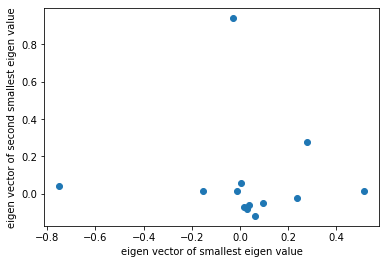

In [184]:
plt.scatter(eig_vec[0],eig_vec[1])
plt.xlabel('eigen vector of smallest eigen value')
plt.ylabel('eigen vector of second smallest eigen value')

For creating the clusters for this data I would use a distance threshold, for each point i will check the distance of other points from that point and all the point falling within the threshold will create a cluster. based on the data i have here there will be 8 clusters where 6 clusters will have 1 point each and the other 2 clusters will have 5 and 2 points.

#### Q6. Markov Clustering: (Total 15 points) Apply markov clustering algorithm on the minmax scaled data, using Gaussian Kernel with $h=0.1, r=3, \epsilon=0.001$. However, after convergence, report only the attractor with the largest number of points. List the attractor index, and the list of points attracted to it.

In [74]:
from scipy.sparse import  csc_matrix
import math
def get_clusters(matrix):

    matrix = csc_matrix(matrix)
    attractors = matrix.diagonal().nonzero()[0]
    clusters = set()
    for attractor in attractors:
        cluster = tuple(matrix.getrow(attractor).nonzero()[1].tolist())
        clusters.add(cluster)

    return sorted(list(clusters)), attractors

In [63]:
def markov(A,r = 3,eps=0.001):
    #new_A = A.copy()
    for i in range(A.shape[0]):
        A[i][i] = 1
    tran_mat = np.zeros(A.shape)
    for i in range(A.shape[0]):
        tran_mat[i][i] = 1/(np.sum(A[i][:]))
    #print(tran_mat)
    M = np.dot(tran_mat,A)
    #print(M)
    diff = 1
    t = 0
    while diff>eps:
        t+=1
        Mt = M*M
        for entry in np.nditer(Mt, op_flags=['readwrite']):
            entry[...] = math.pow(entry, r)
        normalize(Mt, norm="l1", axis=0)
        diff = np.linalg.norm(Mt-M)
        M = Mt
    M_final = Mt
    return M_final

In [71]:
spread = 0.1
A = np.exp(-(np.dot(D.T,D)/ (2*spread)))
matrix = markov(A,r=3)

In [75]:
markov, attractors = get_clusters(matrix)

In [79]:
matrix.shape

(13, 13)

In [81]:
len_atr = 0
lc_idx = 0
for i in range(len(markov)):
    if len(markov[i])>len_atr:
        len_atr = len(markov[i])
        lc_idx = i
print("Attractor index: ", lc_idx, "\nlist of points: ",markov[lc_idx])

Attractor index:  2 
list of points:  (1, 4, 5, 6, 8, 9, 10, 11, 12)


#### Q7. 2D-Convolutions: (Total 10 points) Download the [bookpic_sq.png](https://www.cs.rpi.edu/~zaki/DMCOURSE/images/bookpic_sq.png) image. You can read it into an numpy array via matplotlib imread function, and you can display the image via the matplotlib imshow function. Answer the following questions:

##### a) Read the image into an array and plot it. 
##### b) Next, apply a 2D convolution on this image using a random $k \times k \times c$ mask generated using numpy.random.randn, after setting random seed to 42, where $k=8$ and $c$ corresponds to the number of in_channels in the input image. You must use relu activation, but set the bias to zero. 
##### c) Plot the resulting image using matplotlib imshow function

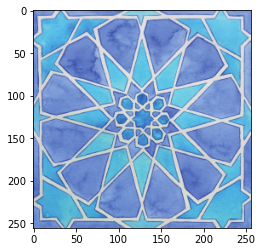

In [185]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('bookpic_sq.png')
imgplot = plt.imshow(img)
plt.show()

In [189]:
np.random.seed(42)
import random

In [202]:
k=8
c=3
np
w=[]
img1 = np.array(img)
for i in range(k*k):
    w.append(random.uniform(0, 1))
w= np.array(w)
w.reshape(k,k)

array([[0.62876378, 0.69172389, 0.95141927, 0.85818829, 0.00962013,
        0.03361721, 0.00924165, 0.63890165],
       [0.68991337, 0.49062503, 0.47476981, 0.70085439, 0.7430146 ,
        0.4991878 , 0.07071799, 0.22859603],
       [0.23552259, 0.45828495, 0.21920478, 0.58439896, 0.20959388,
        0.89733143, 0.79571246, 0.09751568],
       [0.30357554, 0.38501061, 0.320388  , 0.04798165, 0.34527232,
        0.39176244, 0.07030431, 0.88155866],
       [0.89534916, 0.84653784, 0.39306857, 0.01332775, 0.39819969,
        0.65328761, 0.19644562, 0.90415234],
       [0.30418905, 0.92698718, 0.95747279, 0.09190772, 0.51124029,
        0.67577887, 0.75827196, 0.56003984],
       [0.99070452, 0.8562071 , 0.7265506 , 0.33436551, 0.43931864,
        0.4124472 , 0.16693937, 0.10171134],
       [0.2415258 , 0.66259542, 0.88669196, 0.9614417 , 0.22025138,
        0.66121145, 0.59567558, 0.43505279]])